# AmsterdamUMCdb Data Extraction

In this notebook, we will retrieve our patient cohort from the [AmsterdamUMCdb](https://github.com/AmsterdamUMC/AmsterdamUMCdb) and extract relevant (initial) state-space features. We will store the resulting data files in a format similar to the MIMIC-III file format as generated by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code), allowing interoperability between the two datasets and allowing them to share the same subsequent preprocessing pipeline.

More precisely, we will extract the following files:

- **cohort_all_admissions.csv**: contains information on all ICU admissions in the AmsterdamUMCdb, including the start and end-times of each admission and a `hospital_expire_flag` to mark (un)succesful discharge of the patient.
- **demographics_cohort.csv**: demographic information including age, height, weight, on-admission SIRS/SOFA scores, etc.
- **ventilation_cohort.csv**: charted actions related to (non-)invasive mechanical ventilation.
- **antibiotics_cohort.csv**: marks antibiotics received by patients (e.g. profylactic, preventive, antibiotics)
- **vitals_cohort.csv**: vital parameters measured over time including heart rate, respiratory rate, SpO2, systolic/diastolic blood pressure, MAP, CvO2, etc.
- **fio2_cohort.csv**: FiO2 settings (or estimates thereof)
- **vitals_cohort.csv**: lab results including albumin/glucose/ureum levels, PTT test results, hematocrit/hemoglobin/platelets/D-Dimer, etc.
- **urinoutputs_cohort.csv**: urine outputs in mililiters over time
- **vasopressors_cohort.csv**: vasopressor treatment parameters over intervals (starttime, endtime) measured in mcg/kg/min
- **inputevents_cohort.csv**: fluid administration intervals (starttime, endtime) measured in ml

**Important**: Many of the code cells below are inspired by the scripts of Patrick Thoral and Tariq Dam provided in the AmsterdamUMCdb Github repository found [here](https://github.com/AmsterdamUMC/AmsterdamUMCdb).

In [1]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

CHUNK_SIZE = 10000

OUT_DIR = 'D:/amsterdam-umc-db_v2/final/'

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
    os.makedirs(OUT_DIR + 'checkpoints/')

## I/O and Formatting

As the files are in the order of tens of GBs, we read in and process the files incrementally, i.e. in chunks;

In [2]:
def read_csv(path, usecols, chunksize=CHUNK_SIZE):
    """ Reads file limited to columns in `usecols` from path in chunks of size `chunksize` """
    for i, chunk in enumerate(pd.read_csv(path, usecols=usecols, encoding='latin1', engine='c', chunksize=chunksize)):
        yield i, chunk.reset_index(drop=True) # resets index so that indices range from 0 to chunksize - 1

Also, we use a progressbar which shows the number of admissions processed so far, how many there are still to go and the estimated time left;

In [3]:
def pbar(iterator, total_admissions=23106):
    # Keep track of admissions already seen
    processed_admissions = set()
    
    with tqdm(total=total_admissions) as progress_bar:
        for i, chunk in iterator:
            
            # count number of new admissions not yet seen
            # we do it only if last admission is new (saves time checking)
            if chunk.admissionid.values[-1] not in processed_admissions:
                new_admissions = set(chunk.admissionid) - processed_admissions
                processed_admissions.update(new_admissions)
            
                # update progress bar
                progress_bar.update(len(new_admissions))
                
            yield i, chunk

---
## Times
Times, e.g. `administeredat` of a vital measurement, are defined in milliseconds relative to the first admission of that same patient (which itself has a starttime of 0ms). As this can be hard to reason over, we convert charttimes in the dataset to absolute timestamps (of the form `YYYY-MM-DD HH:mm:ss.xxxxxx`) and define the start of the first admission of each patient as the 1st of january 2022 at midnight (we can choose this arbitrarily as long as we stay consistent);

In [4]:
# Start times of admissions relative to the first admission (with start = 0)
start_of_admission_ms = dict()
for _, chunk in read_csv(r"D:/AmsterdamUMCdb-v1.0.2/admissions.csv", usecols=['admissionid', 'admittedat']):
    # admissionid + admission time
    start_of_admission_ms.update(dict(zip(chunk.admissionid, chunk.admittedat)))

print('Time since last admission: %.2f years' % (start_of_admission_ms[5489] / (1000 * 60 * 60 * 24 * 365)))

Time since last admission: 1.51 years


#### Convenience functions

In [5]:
# unit conversions
def hours_to_ms(hours):
    return hours * 1000 * 3600

def ms_to_hours(ms):
    return ms / (1000 * 3600)

In [6]:
# creates a timestamp by adding relative miliseconds to some chosen starttime (e.g. chosen time stamp of start first admission)
def to_timestamp(starttime, ms):       
    return starttime + pd.to_timedelta(arg=ms, unit='ms')

# computes time in hours within current admission from ms relative to first admission
def hours_in_admission(ms, admissionid):
    ms_since_first_admission = admissionid.transform(lambda x: start_of_admission_ms[x] if x in start_of_admission_ms else 0)
    return ms_to_hours(ms - ms_since_first_admission)

In [7]:
# for all first admissions, assume start date is now
first_admission_start = pd.Timestamp('2022-01-01T00:00:00')

print('Admission start:  ', first_admission_start)
print('Two hours in:     ', to_timestamp(first_admission_start, ms=hours_to_ms(2)))

Admission start:   2022-01-01 00:00:00
Two hours in:      2022-01-01 02:00:00


---

## Patient cohort

We define our cohort as all patient admitted to the ICU, therefore no further filtering is performed here

In [38]:
cohort_df = []
for i, chunk in read_csv(r"D:/AmsterdamUMCdb-v1.0.2/admissions.csv", usecols=['admissionid', 'admittedat', 'destination']):
    # infer whether patient passed away in-hospital (1) or succesfully discharged (0)
    expire_flag = chunk.destination == 'Overleden'
    
    # determine start- and end-time of admission in hours
    # Note: As a proxy for the start of first admission we use the time of running this notebook
    window_start = to_timestamp(first_admission_start, ms=chunk.admittedat)
    window_end = to_timestamp(first_admission_start, ms=chunk.admittedat + hours_to_ms(72))
    
    chunk_df = pd.DataFrame({
        'icustay_id': chunk.admissionid,
        'window_start': window_start,
        'window_end': window_end,
        'hospital_expire_flag': expire_flag.astype(int),
    })
    cohort_df.append(chunk_df)
    
# merge
cohort_df = pd.concat(cohort_df, axis=0).reset_index(drop=True)
cohort_df.head()

,icustay_id,window_start,window_end,hospital_expire_flag
0,0,2022-01-01,2022-01-04,0
1,1,2022-01-01,2022-01-04,0
2,2,2022-01-01,2022-01-04,0
3,3,2022-01-01,2022-01-04,0
4,4,2022-01-01,2022-01-04,0


In [39]:
print('Mortality rate', cohort_df.hospital_expire_flag.mean())

Mortality rate 0.09902189907383363


In [40]:
# save!
cohort_df.to_csv(OUT_DIR + 'cohort.csv', index=False)

----

## Demographics

### Mechanical ventilation (on-admission)

Source: [mechanical_ventilation.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/lifesupport/mechanical_ventilation.sql)

In [12]:
# Combinations of itemids and valueids in listitems.csv indicating
# use of invasive or non-invasive mechanical ventilation
MECH_VENT_SETTINGS = [
    (9534, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)),                    # --Type beademing Evita 1
    (6685, (1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 20, 22)),                 # --Type Beademing Evita 4
    (8189, (16,)),                                                          # --Toedieningsweg O2
    (12290, (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)),  # --Ventilatie Mode (Set) Servo-I and Servo-U ventilators
    (12347, (2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18)),  # --Ventilatie Mode (Set) (2) Servo-I and Servo-U ventilators
    (12376, (1, 2)),                                                        # --Mode (Bipap Vision)
]    

In [13]:
# to help check whether some (itemid, valueid) pair in listitems indicates use of ventilator
class Ventilation():
    def __init__(self, mech_vent):
        """ Helper class to check for mechanical ventilation
        """
        self._vent_settings = set()
        for itemid, valueids in mech_vent:
            self._vent_settings.update([(itemid, valueid) for valueid in valueids])
            
    def __call__(self, itemids, valueids):
        """ Checks if (itemid, valueid) pair is a valid ventilator settings """
        return np.array([x in self._vent_settings for x in list(zip(itemids, valueids))])
    
is_mech_vent = Ventilation(MECH_VENT_SETTINGS)

For each admission, see if mechanical ventilation is used in the first X hours of admission (defined by `START_OF_ADMISSION`) (see Roggeveen et al., 2021)

In [14]:
admissions_with_vent = set()

for _, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/listitems.csv", usecols=['admissionid', 'itemid', 'valueid', 'measuredat'])):
    # which observations are within 12 hours of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    within_12h = (times > 0) & (times < 12)
    
    # which admissions indicate the use of ventilatory support in that time window?
    adm_with_vent = chunk[within_12h & is_mech_vent(chunk.itemid, chunk.valueid)].admissionid
    
    admissions_with_vent.update(adm_with_vent)
        
print('Number of admissions with ventilation:', len(admissions_with_vent))

100%|███████████████████████████████████████████████████████████████████████████| 23106/23106 [01:44<00:00, 221.89it/s]

Number of admissions with ventilation: 16098


### Glasgow Coma Scale (on-admission)
Sources: 
- Glasgow Coma Scale: [gcs.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/gcs.sql)
- GCS definition: https://www.mdcalc.com/calc/64/glasgow-coma-scale-score-gcs

In [15]:
## credits Patrick Thoral

def gcs_eyes_score(df):
    df.loc[df.itemid == 6732, 'eyes_score'] = 5 - df.valueid   # --Actief openen van de ogen
    df.loc[df.itemid == 13077, 'eyes_score'] = df.valueid      # --A_Eye
    df.loc[df.itemid == 14470, 'eyes_score'] = df.valueid - 4  # --RA_Eye
    df.loc[df.itemid == 16628, 'eyes_score'] = df.valueid - 4  # --MCA_Eye
    df.loc[df.itemid == 19635, 'eyes_score'] = df.valueid - 4  # --E_EMV_NICE_24uur
    df.loc[df.itemid == 19638, 'eyes_score'] = df.valueid - 8  # --E_EMV_NICE_Opname
    return df
    
def gcs_motor_score(df):
    df.loc[df.itemid == 6734, 'motor_score'] = 7 - df.valueid   # --Beste motore reactie van de armen
    df.loc[df.itemid == 13072, 'motor_score'] = df.valueid      # --A_Motoriek
    df.loc[df.itemid == 14476, 'motor_score'] = df.valueid - 6  # --RA_Motoriek
    df.loc[df.itemid == 16634, 'motor_score'] = df.valueid - 6  # --MCA_Motoriek
    df.loc[df.itemid == 19636, 'motor_score'] = df.valueid - 6  # --M_EMV_NICE_24uur
    df.loc[df.itemid == 19639, 'motor_score'] = df.valueid - 12 # --M_EMV_NICE_Opname
    return df

def gcs_verbal_score(df):
    df.loc[df.itemid == 6735, 'verbal_score'] = 6 - df.valueid   # --Beste verbale reactie
    df.loc[df.itemid == 13066, 'verbal_score'] = df.valueid      # --A_Verbal
    df.loc[df.itemid == 14482, 'verbal_score'] = df.valueid - 5  # --RA_Verbal
    df.loc[df.itemid == 16640, 'verbal_score'] = df.valueid - 5  # --MCA_Verbal
    df.loc[df.itemid == 19637, 'verbal_score'] = df.valueid - 9  # --V_EMV_NICE_24uur
    df.loc[df.itemid == 19640, 'verbal_score'] = df.valueid - 15 # --M_EMV_NICE_Opname
    
    # cap verbal score to at least 1
    df.loc[df['verbal_score'] < 1, 'verbal_score'] = 1
    return df

In [16]:
gcs_on_admission = dict()

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/listitems.csv", usecols=['admissionid', 'itemid', 'valueid', 'measuredat'])): 
    # which observations are within 12h of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 12)].copy()
    
    # component scores
    chunk = gcs_eyes_score(chunk)
    chunk = gcs_motor_score(chunk)
    chunk = gcs_verbal_score(chunk)
        
    # GCS = eye + motor + verbal score
    gcs = chunk.groupby('admissionid').first()[['eyes_score', 'motor_score', 'verbal_score']].sum(axis=1, min_count=3) # need all three component scores else NaN!
    
    # add GCS scores for admissions we could compute it for
    gcs = gcs[gcs.notna()].to_dict()
    gcs_on_admission.update(gcs)

100%|███████████████████████████████████████████████████████████████████████████| 23106/23106 [01:58<00:00, 194.58it/s]


In [17]:
print('GCS on start of admission 11:', gcs_on_admission[11])
print('Admissions with available GCS scores:', len(gcs_on_admission))

GCS on start of admission 11: 3.0
Admissions with available GCS scores: 12513


### Estimating FiO2

For computing the SOFA score we need to have an estimate of the fraction of inspired oxygen (FiO2). As this is not readily known for patients not on ventilatory support we must estimate it from the O2 flow and oxygen device used (see [sofa.ipynb](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/concepts/severityscores/sofa.ipynb) and the data dictionary by [Stichting NICE](https://www.stichting-nice.nl/dd/#468));

#### Oxygen device settings, PaCo2 and PaO2

In [8]:
OXY_FLOW_NO_SUPP = [
    8845,  # -- O2 l/min
    10387, # --Zuurstof toediening (bloed)
    18587  # --Zuurstof toediening
]

OXY_FLOW_RESP_SUPP = [
    6699,  # --FiO2 %: setting on Evita ventilator
    12279, # --O2 concentratie --measurement by Servo-i/Servo-U ventilator
    12369, # --SET %O2: used with BiPap Vision ventilator
    16246  # --Zephyros FiO2: Non-invasive ventilation
]

PAO2 = [
    7433, # --PO2
    9996, # --PO2 (bloed)
    21214 # --PO2 (bloed) - kPa
]

PACO2 = [
    6846, # --PCO2
    9990, # --pCO2 (bloed)
    21213 # --PCO2 (bloed) - kPa
]

In [17]:
## Oxygen device and O2 flow from numericitems
oxy_devices = []
pao2 = []
paco2 = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/numericitems.csv", usecols=['admissionid', 'itemid', 'unitid', 'value', 'measuredat'])):    
    # Oxygen device settings
    oxy_chunk = chunk[chunk.itemid.isin(OXY_FLOW_NO_SUPP + OXY_FLOW_RESP_SUPP)]
    if len(oxy_chunk) > 0:
        oxy_devices.append(oxy_chunk)
        
    # Convert PaO2/PaCO2 units from kPa to mmHg
    chunk.loc[chunk.unitid == 152, 'value'] = chunk.value * 7.50061683
    
    # PaO2
    pao2_chunk = chunk[chunk.itemid.isin(PAO2)].rename({'value': 'pao2'}, axis=1)
    if len(pao2_chunk) > 0:
        pao2.append(pao2_chunk)
    
    # PaCO2
    paco2_chunk = chunk[chunk.itemid.isin(PACO2)].rename({'value': 'paco2'}, axis=1)
    if len(paco2_chunk) > 0:
        paco2.append(paco2_chunk)
    
# merge 
oxy_devices = pd.concat(oxy_devices, axis=0)
pao2 = pd.concat(pao2, axis=0)
paco2 = pd.concat(paco2, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 23106/23106 [33:27<00:00, 11.51it/s]


In [18]:
print('Oxygen devices:')
oxy_devices.to_csv(OUT_DIR + 'checkpoint_oxy_devices.csv')
oxy_devices.head()

Oxygen devices:


,admissionid,itemid,value,unitid,measuredat
525,0,8845,6.0,26,60720000
526,0,8845,6.0,26,65520000
527,0,8845,10.0,26,69120000
528,0,8845,15.0,26,69180000
529,0,8845,15.0,26,72720000


In [19]:
print('PaO2:')
pao2.to_csv(OUT_DIR + 'checkpoint_pao2.csv')
pao2.head()

PaO2:


,admissionid,itemid,pao2,unitid,measuredat
729,0,9996,71.0,173,-978000000
730,0,9996,90.0,173,20520000
731,0,9996,149.0,173,25920000
732,0,9996,104.0,173,33120000
733,0,9996,32.0,173,36720000


In [20]:
print('PaCO2:')
paco2.to_csv(OUT_DIR + 'checkpoint_paco2.csv')
paco2.head()

PaCO2:


,admissionid,itemid,paco2,unitid,measuredat
683,0,9990,41.0,173,-978000000
684,0,9990,39.0,173,20520000
685,0,9990,37.0,173,25920000
686,0,9990,36.0,173,33120000
687,0,9990,43.0,173,36720000


#### Estimating FiO2

In [25]:
# For each admission estimate FiO2 from Oxygen Flow settings without respiratory support
estimated_fio2 = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/listitems.csv", usecols=['admissionid', 'itemid', 'valueid', 'measuredat'])): 
    ## -- Toedieningsweg (Oxygen device)
    chunk = chunk[chunk.itemid == 8189]
    if len(chunk) == 0:
        continue
    
    # merge valueid of oxy_devices by admission and measurementtime
    # Note: we first limit oxy_devices before merge to admissionids of chunk to reduce runtime from 3 hours -> 8 min
    chunk_oxy_devices = oxy_devices[oxy_devices.admissionid.isin(chunk.admissionid.unique())]
    chunk = chunk.merge(chunk_oxy_devices, on=['admissionid', 'measuredat'], how='inner').copy().reset_index(drop=True)
    if len(chunk) == 0:
        continue
    
    # Set all FiO2 to their expected "regular air" baseline
    chunk.loc[:, 'fio2'] = 0.21
        
    # Option 1: Patient received ventilatory support, thus FiO2 can be read off from settings
    fio2_known = chunk.itemid_y.isin(OXY_FLOW_RESP_SUPP)
    chunk.loc[fio2_known, 'fio2'] = chunk.value.fillna(0.21)
    
    # Option 2: Patient did not receive vent. support, thus we must estimate FiO2
    # Source: https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/common/pO2_FiO2_estimated.sql
    cat1 = chunk.valueid.isin([2, 7])
    chunk.loc[~fio2_known & cat1 & (chunk.value >= 1) & (chunk.value < 2), 'fio2'] = 0.22
    chunk.loc[~fio2_known & cat1 & (chunk.value >= 2) & (chunk.value < 3), 'fio2'] = 0.25
    chunk.loc[~fio2_known & cat1 & (chunk.value >= 3) & (chunk.value < 4), 'fio2'] = 0.27
    chunk.loc[~fio2_known & cat1 & (chunk.value >= 4) & (chunk.value < 5), 'fio2'] = 0.30
    chunk.loc[~fio2_known & cat1 & (chunk.value >= 5), 'fio2'] = 0.35
    
    cat2 = chunk.valueid.isin([1, 3, 8, 9, 4, 18, 19])
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 1) & (chunk.value < 2), 'fio2'] = 0.22
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 2) & (chunk.value < 3), 'fio2'] = 0.25
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 3) & (chunk.value < 4), 'fio2'] = 0.27
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 4) & (chunk.value < 5), 'fio2'] = 0.30
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 5) & (chunk.value < 6), 'fio2'] = 0.35
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 6) & (chunk.value < 7), 'fio2'] = 0.40
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 7) & (chunk.value < 8), 'fio2'] = 0.45
    chunk.loc[~fio2_known & cat2 & (chunk.value >= 8), 'fio2'] = 0.50
    
    cat3 = chunk.valueid.isin([10, 11, 13, 14, 15, 16, 17])
    chunk.loc[~fio2_known & cat3 & (chunk.value >= 6) & (chunk.value < 7), 'fio2'] = 0.60
    chunk.loc[~fio2_known & cat3 & (chunk.value >= 7) & (chunk.value < 8), 'fio2'] = 0.70
    chunk.loc[~fio2_known & cat3 & (chunk.value >= 8) & (chunk.value < 9), 'fio2'] = 0.80
    chunk.loc[~fio2_known & cat3 & (chunk.value >= 9) & (chunk.value < 10), 'fio2'] = 0.85
    chunk.loc[~fio2_known & cat3 & (chunk.value >= 10), 'fio2'] = 0.90
    
    estimated_fio2.append(chunk[['admissionid', 'measuredat', 'fio2']])
    
# merge 
estimated_fio2 = pd.concat(estimated_fio2, axis=0)
estimated_fio2.head()

100%|████████████████████████████████████████████████████████████████████████████| 23106/23106 [08:24<00:00, 45.76it/s]


,admissionid,measuredat,fio2
0,0,60720000,0.35
1,0,65520000,0.35
2,0,69120000,0.50
3,0,69180000,0.90
4,0,72720000,0.90


In [26]:
estimated_fio2.to_csv(OUT_DIR + 'checkpoint_estimated_fio2.csv')

#### Merge with PaO2 and PaCO2 (for PF-ratio)

In [12]:
# merge PaO2, PaCO2 into one DataFrame by admission and measurement time
chunk_paco2 = paco2[paco2.admissionid.isin(pao2.admissionid.unique())]
merged_pao2_paco2 = pao2.merge(paco2, on=['admissionid', 'measuredat'], how='inner', suffixes=('_pao2', '_paco2'))
print('Merged PaCO2 and PaO2!')

# merge with FiO2 within window of -60 min to 15 min from a PaO2/PaCO2 measurement
# limit admissionids!
chunk_fio2 = estimated_fio2[estimated_fio2.admissionid.isin(merged_pao2_paco2.admissionid.unique())]
chunk_pao2 = merged_pao2_paco2[merged_pao2_paco2.admissionid.isin(merged_pao2_paco2.admissionid.unique())]

merged_fio2 = chunk_pao2.merge(chunk_fio2, on='admissionid', how='inner', suffixes=('', '_fio2'))
print('Merged FiO2!')

merged_fio2 = merged_fio2[
    (merged_fio2.measuredat_fio2 > (merged_fio2.measuredat - 60 * 60 * 1000)) &\
    (merged_fio2.measuredat_fio2 < (merged_fio2.measuredat + 15 * 60 * 1000))
]
merged_fio2.head()

Merged paco2 and pao2!
Merged fio2!


,Unnamed: 0_pao2,admissionid,itemid_pao2,pao2,unitid_pao2,measuredat,Unnamed: 0_paco2,itemid_paco2,paco2,unitid_paco2,Unnamed: 0,measuredat_fio2,fio2
154,736,0,9996,72.0,173,61920000,690,9990,43.0,173,0,60720000,0.35
178,737,0,9996,65.0,173,69120000,691,9990,45.0,173,2,69120000,0.50
179,737,0,9996,65.0,173,69120000,691,9990,45.0,173,3,69180000,0.90
203,738,0,9996,122.0,173,76320000,692,9990,42.0,173,5,76320000,0.90
227,739,0,9996,103.0,173,83520000,693,9990,48.0,173,7,83520000,0.90


In [13]:
merged_fio2.to_csv(OUT_DIR + 'checkpoint_merged_fio2.csv')

### Severity Scores
SIRS sources:
- Temperature: [temperature.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/temperature.sql)
- Heart rate: [heart_rate.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/heart_rate.sql)
- Respiratory rate: [resp_rate.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/resp_rate.sql)
- WBC/Leukocytes: [wbc.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/wbc.sql)
- SIRS definition: https://www.mdcalc.com/calc/1096/sirs-sepsis-septic-shock-criteria

SOFA sources:
- PaO2/FiO2: [pO2_pCO2_FiO2.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/pO2_pCO2_FiO2.sql)
- Ventilators: [mechanical_ventilation.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/lifesupport/mechanical_ventilation.sql)
- Platelets: [platelets.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/platelets.sql)
- Glasgow Coma Scale: [gcs.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/gcs.sql)
- Bilirubin: [bilirubin.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/b6f295fbfbd9a1f8f9cfa71dab58c670120543d8/amsterdamumcdb/sql/common/bilirubin.sql)
- SOFA definition: https://www.mdcalc.com/calc/691/sequential-organ-failure-assessment-sofa-score

In [16]:
TEMPERATURE = [
    8658,  # --Temp Bloed
    8659,  # --Temperatuur Perifeer 2
    8662,  # --Temperatuur Perifeer 1
    13058, # --Temp Rectaal
    13059, # --Temp Lies
    13060, # --Temp Axillair
    13061, # --Temp Oraal
    13062, # --Temp Oor
    13063, # --Temp Huid
    13952, # --Temp Blaas
    16110  # --Temp Oesophagus
]

HEARTRATE = [
    6640   # --Hartfrequentie
]

RESP_RATE = [
    8873,  # --Ademfrequentie Evita: measurement by Evita ventilator, most accurate
    12266, # --Ademfreq.: measurement by Servo-i/Servo-U ventilator, most accurate
    8874   # --Ademfrequentie Monitor: measurement by patient monitor using ECG-impedance, less accurate  
]

WBC = [
    6779,  # --Leucocyten 10^9/l
    9965   # --Leuco's (bloed) 10^9/l
]

BANDS = [
    11586  # -- Staaf % (bloed)
]

## PaO2, PaCO2 and FiO2 were previously estimated :)

PLATELETS = [
    9964,  # --Thrombo's (bloed)
    6797,  # --Thrombocyten
    10409, # --Thrombo's citr. bloed (bloed)
    14252  # --Thrombo CD61 (bloed)   
]

BILIRUBIN = [
    6813,  # --Bili Totaal
    9945   # --Bilirubine (bloed)
]

MEANBP = [
    6642,  # --ABP gemiddeld
    6679,  # --Niet invasieve bloeddruk gemiddeld
    8843   # --ABP gemiddeld II
]

CREATININE = [
    6836,  # --Kreatinine µmol/l (erroneously documented as µmol)
    9941,  # --Kreatinine (bloed) µmol/l
    14216  # --KREAT enzym. (bloed) µmol/l   
]

For each chunk of the `numericitems.csv` with a few admissions (actually quite a few), we will extract the above parameters (i.e. temperature, heart rate, pCO2, leukocyte count, etc.) and infer their earliest values within the admission. We follow Roggeveen et al. and limit these values to at most 8 hours after the start of admission. We then compute the SIRS and SOFA scores from those parameters.

#### SIRS

In [17]:
def compute_sirs(resp_rate, paco2, temp, heart_rate, wbc, bands):
    """ Computes Systemic inflammatory response syndrome (SIRS) score given vital parameters 
    For details, see: http://www.mdcalc.com/calc/1096/sirs-sepsis-septic-shock-criteria
    
    :param *kwargs: dicts mapping from admissionids to vital parameters at the beginning of the admission (if known)
    """
    # which admissions have available the data to estimate SIRS?
    admissionids = temp.keys() & heart_rate.keys() & (resp_rate.keys() | paco2.keys()) & (wbc.keys() | bands.keys())
    
    # compute SIRS for eligible admissions
    out = dict()
    for admissionid in admissionids:
        score = int(temp[admissionid] < 36 or temp[admissionid] > 38)
        score += int(heart_rate[admissionid] > 90)
        score += int(resp_rate[admissionid] > 20) if admissionid in resp_rate else int(paco2[admissionid] < 32)
        score += int(wbc[admissionid] > 12 or wbc[admissionid] < 4) if admissionid in wbc else int(bands[admissionid] > 10)
        
        out[admissionid] = score
    return out

#### SOFA

In [18]:
def compute_sofa(po2, fio2, vent, platelets, gcs, bilirubin, meanbp, creatinine):
    """ Computes Sequential Organ Failure Assessment (SOFA) score given vital parameters 
    For details, see: https://files.asprtracie.hhs.gov/documents/aspr-tracie-sofa-score-fact-sheet.pdf
    
    :param *kwargs: dicts mapping from admissionids to vital parameters at the beginning of the admission (if known)
    """
    # which admissions have available the data to estimate SOFA?
    admissionids = po2.keys() & fio2.keys() & vent.keys() & platelets.keys() & bilirubin.keys() & meanbp.keys() & creatinine.keys() & gcs.keys()
    
    # compute SIRS for eligible admissions
    out = dict()
    for admissionid in admissionids:
        score = 0
        
        # respiratory
        pf_ratio = po2[admissionid] / fio2[admissionid]
        if pf_ratio < 100 and vent[admissionid]:
            score += 4
        elif pf_ratio < 200 and vent[admissionid]:
            score += 3
        elif pf_ratio < 300:
            score += 2
        elif pf_ratio < 400:
            score += 1
            
        # coagulation
        coag = platelets[admissionid]
        if coag < 20:
            score += 4
        elif coag < 50:
            score += 3
        elif coag < 100:
            score += 2
        elif coag < 150:
            score += 1
            
        # liver
        bili = bilirubin[admissionid] 
        if bili >= 12:
            score += 4
        elif 6 <= bili < 12:
            score += 3
        elif 2 <= bili < 6:
            score += 2
        elif 1.2 <= bili < 2:
            score += 1
            
        # cardiovascular
        # TODO: add vasopressor agents
        blood_pressure = meanbp[admissionid] 
        if blood_pressure < 70:
            score += 1
        
        # central nervous system
        gcs_score = gcs[admissionid]
        if gcs_score < 6:
            score += 4
        elif 6 <= gcs_score <= 9:
            score += 3
        elif 10 <= gcs_score <= 12:
            score += 2
        elif 13 <= gcs_score <= 14:
            score += 1
            
        # renal
        creat = creatinine[admissionid]
        if creat > 440:
            score += 4
        elif 300 <= creat < 440:
            score += 3
        elif 170 <= creat < 300:
            score += 2
        elif 110 <= creat < 170:
            score += 1
        
        out[admissionid] = score
    return out

In [19]:
merged_fio2 = pd.read_csv(OUT_DIR + 'checkpoint_merged_fio2.csv')

#### \*Deep breath\*

In [22]:
sirs_on_admission = dict()
sofa_on_admission = dict()

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/numericitems.csv", usecols=['admissionid', 'itemid', 'value', 'measuredat', 'unitid'])):
    
    # which observations are within 12h of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 12)]
    
    if len(chunk) == 0:
        continue
        
    #########
    #  SIRS
    #########
    
    # Respiratory rate (unit = breaths/min)
    resp_rate = chunk[chunk.itemid.isin(RESP_RATE) & (chunk.unitid == 15)]
    resp_rate = resp_rate.groupby('admissionid', sort=False).value.first().to_dict()
    
    # PaCO2, PaO2 (mmHg) and FiO2 (%)
    chunk_merged_fio2 = merged_fio2[merged_fio2.admissionid.isin(chunk)]
    gas_tension = chunk.merge(chunk_merged_fio2, on='admissionid')
    gas_tension = gas_tension.groupby('admissionid', sort=False).first()
    pao2_ = gas_tension.pao2.to_dict()
    paco2_ = gas_tension.paco2.to_dict()
    fio2_ = gas_tension.fio2.to_dict()
        
    # Temperature (degrees C)
    temp = chunk[chunk.itemid.isin(TEMPERATURE) & (chunk.unitid == 59)]
    temp = temp.groupby('admissionid', sort=False).value.first().to_dict()
    
    # Heart rate (beats/min)
    heart_rate = chunk[chunk.itemid.isin(HEARTRATE) & (chunk.unitid == 15)]
    heart_rate = heart_rate.groupby('admissionid', sort=False).value.first().to_dict()
    
    # Leukocytes (10^9/l)
    wbc = chunk[chunk.itemid.isin(WBC) & (chunk.unitid == 101)]
    wbc = wbc.groupby('admissionid', sort=False).value.first().to_dict()
    
    # Bands (bloed %)
    bands = chunk[chunk.itemid.isin(BANDS)]
    bands = bands.groupby('admissionid', sort=False).value.first().to_dict()
        
    sirs = compute_sirs(resp_rate, paco2_, temp, heart_rate, wbc, bands)
    sirs_on_admission.update(sirs)
    
    #########
    #  SOFA
    #########
    
    # Mechanical ventilation
    vent = {a:(1 if a in admissions_with_vent else 0) for a in chunk.admissionid.unique()}
    
    # Platelets (10^9/l)
    platelets = chunk[chunk.itemid.isin(PLATELETS)]
    platelets = platelets.groupby('admissionid', sort=False).value.first().to_dict()
    
    # Bilirubin (µmol/l)
    bilirubin = chunk[chunk.itemid.isin(BILIRUBIN)]
    bilirubin = bilirubin.groupby('admissionid', sort=False).value.first().to_dict()
    
    # MAP (mmHg)
    map_ = chunk[chunk.itemid.isin(MEANBP)]
    map_ = map_.groupby('admissionid', sort=False).value.first().to_dict()
    
    # Creatinine (µmol/l)
    creatinine = chunk[chunk.itemid.isin(CREATININE)]
    creatinine = creatinine.groupby('admissionid', sort=False).value.first().to_dict()
    
    sofa = compute_sofa(pao2_, fio2_, vent, platelets, gcs_on_admission, bilirubin, map_, creatinine)
    sofa_on_admission.update(sofa)
    
    # if i > MAX_CHUNKS:
    #     break

100%|██████████████████████████████████████████████████████████████████████████| 23106/23106 [1:10:17<00:00,  5.48it/s]


In [25]:
sirs_on_admission[11]  # SIRS of admission 11 in first 12h

2

In [27]:
import pickle

with open(OUT_DIR + 'checkpoint_sirs_on_admission.pkl', 'wb') as file:
    pickle.dump(sirs_on_admission, file)
    
with open(OUT_DIR + 'checkpoint_sofa_on_admission.pkl', 'wb') as file:
    pickle.dump(sofa_on_admission, file)

### Age, Height, Weight, Gender

In [27]:
# Age/weight/height groups to their centroids (best guess)
AGE_GROUPS = {
    '18-39': 30,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75, 
    '80+': 85  # Arbitrary
}

WEIGHT_GROUPS = {
    '59-': 55,
    '60-69': 65, 
    '70-79': 75,
    '80-89': 85,
    '90-99': 95,
    '100-109': 105,
    '110+': 115,
    'N/A': np.NaN # To be replaced with Dutch average weight (for men and women separately)
}
  
HEIGHT_GROUPS = {
    '159-': 155,
    '160-169': 165,
    '170-179': 175,
    '180-189': 185, 
    '190+': 195, 
    'N/A': np.NaN  # To be replaced with average height of men and women in NL
}

# Average weight/height of Dutch men/women
AVG_MALE_HEIGHT = 181 # cm
AVG_MALE_WEIGHT = 84  # kg
AVG_FEMALE_HEIGHT = 168
AVG_FEMALE_WEIGHT = 70

Using the above dictionaries we can now map from grouped demographics (`agegroup`, `heightgroup`, `weightgroup`) to a real value. When unknown use per-gender guesses of weight and height (better than a naive average over the population)

### Reason for admission

Source: [reason_for_admission.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/diagnosis/reason_for_admission.sql)

In [29]:
IS_SURGICAL = [
    13116, # --D_Thoraxchirurgie_CABG en Klepchirurgie
    16671, # --DMC_Thoraxchirurgie_CABG en Klepchirurgie
    13117, # --D_Thoraxchirurgie_Cardio anders
    16672, # --DMC_Thoraxchirurgie_Cardio anders
    13118, # --D_Thoraxchirurgie_Aorta chirurgie
    16670, # --DMC_Thoraxchirurgie_Aorta chirurgie
    13119, # --D_Thoraxchirurgie_Pulmonale chirurgie
    16673, # --DMC_Thoraxchirurgie_Pulmonale chirurgie
    
    13121, # --D_Algemene chirurgie_Buikchirurgie
    16643, # --DMC_Algemene chirurgie_Buikchirurgie
    13123, # --D_Algemene chirurgie_Endocrinologische chirurgie
    16644, # --DMC_Algemene chirurgie_Endocrinologische chirurgie
    13145, # --D_Algemene chirurgie_KNO/Overige
    16645, # --DMC_Algemene chirurgie_KNO/Overige
    13125, # --D_Algemene chirurgie_Orthopedische chirurgie
    16646, # --DMC_Algemene chirurgie_Orthopedische chirurgie
    13122, # --D_Algemene chirurgie_Transplantatie chirurgie
    16647, # --DMC_Algemene chirurgie_Transplantatie chirurgie
    13124, # --D_Algemene chirurgie_Trauma
    16648, # --DMC_Algemene chirurgie_Trauma
    13126, # --D_Algemene chirurgie_Urogenitaal
    16649, # --DMC_Algemene chirurgie_Urogenitaal
    13120, # --D_Algemene chirurgie_Vaatchirurgie
    16650, # --DMC_Algemene chirurgie_Vaatchirurgie

    13128, # --D_Neurochirurgie _Vasculair chirurgisch
    16661, # --DMC_Neurochirurgie _Vasculair chirurgisch
    13129, # --D_Neurochirurgie _Tumor chirurgie
    16660, # --DMC_Neurochirurgie _Tumor chirurgie
    13130, # --D_Neurochirurgie_Overige
    16662, # --DMC_Neurochirurgie_Overige

    18596, # --Apache II Operatief Gastr-intenstinaal
    18597, # --Apache II Operatief Cardiovasculair
    18598, # --Apache II Operatief Hematologisch
    18599, # --Apache II Operatief Metabolisme
    18600, # --Apache II Operatief Neurologisch
    18601, # --Apache II Operatief Renaal
    18602, # --Apache II Operatief Respiratoir

    17008, # --APACHEIV Post-operative cardiovascular
    17009, # --APACHEIV Post-operative gastro-intestinal
    17010, # --APACHEIV Post-operative genitourinary
    17011, # --APACHEIV Post-operative hematology
    17012, # --APACHEIV Post-operative metabolic
    17013, # --APACHEIV Post-operative musculoskeletal /skin
    17014, # --APACHEIV Post-operative neurologic
    17015, # --APACHEIV Post-operative respiratory
    17016, # --APACHEIV Post-operative transplant
    17017  # --APACHEIV Post-operative trauma   
]

In [30]:
is_elective = set() # equiv. to surgical
is_sepsis = set()

for _, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/listitems.csv", usecols=['admissionid', 'itemid', 'valueid', 'measuredat'])):
    
    # Was sepsis explicitly diagnosed
    sepsis_chunk = chunk[(chunk.itemid == 15808) & (chunk.valueid == 1)] # 'opname sepsis' + 'Ja'
    is_sepsis.update(sepsis_chunk.admissionid)
    
    # Post-operative (i.e. elective) admission
    post_surg_chunk = chunk[
        chunk.itemid.isin(IS_SURGICAL) | 
        ((chunk.itemid == 18669) & ((chunk.valueid >= 1) | (chunk.valueid <= 26))) | 
        ((chunk.itemid == 18671) & ((chunk.valueid >= 222) | (chunk.valueid <= 452)))
    ]
    is_elective.update(post_surg_chunk.admissionid)

100%|███████████████████████████████████████████████████████████████████████████| 23106/23106 [01:08<00:00, 337.15it/s]


### Merge as DataFrame

In [33]:
demo_cols = ['admissionid', 'gender', 'agegroup', 'heightgroup', 'weightgroup']

demo_df = []
for i, chunk in read_csv(r"D:/AmsterdamUMCdb-v1.0.2/admissions.csv", usecols=demo_cols, chunksize=100000000):
    demo_chunk = pd.DataFrame({
        'icustay_id': chunk.admissionid,
        'age': chunk.agegroup.transform(lambda x: AGE_GROUPS[x] if x in AGE_GROUPS else np.NaN),
        'is_male': (chunk.gender == 'Man').astype(int),
        'height': chunk.heightgroup.transform(lambda x: HEIGHT_GROUPS[x] if x in HEIGHT_GROUPS else np.NaN),
        'weight': chunk.weightgroup.transform(lambda x: WEIGHT_GROUPS[x] if x in WEIGHT_GROUPS else np.NaN),
        'vent': chunk.admissionid.isin(admissions_with_vent).astype(int),
        'sirs': chunk.admissionid.transform(lambda x: sirs_on_admission[x] if x in sirs_on_admission else np.NaN),  # NaN if couldn't be estimated
        'sofa': chunk.admissionid.transform(lambda x: sofa_on_admission[x] if x in sofa_on_admission else np.NaN),  # NaN if couldn't be estimated
        'elective': chunk.admissionid.transform(lambda x: 1 if x in is_elective else 0),
        'is_sepsis': chunk.admissionid.transform(lambda x: 1 if x in is_sepsis else 0),
    })
    demo_df.append(demo_chunk)
    
demo_df = pd.concat(demo_df, axis=0).reset_index(drop=True)

#### Missing height/weights

Instead of using an overall average of weights/heights in the dataset to impute missing weight/height values, we opt for per-gender estimates of adult men and women in the Netherlands as this will likely give us more precise values.

In [34]:
# If weight/height unknown but gender is, used per-gender estimates
demo_df.loc[demo_df.height.isna() & demo_df.is_male, 'height'] = AVG_MALE_HEIGHT
demo_df.loc[demo_df.weight.isna() & demo_df.is_male, 'weight'] = AVG_MALE_WEIGHT
demo_df.loc[demo_df.height.isna() & ~demo_df.is_male, 'height'] = AVG_FEMALE_HEIGHT
demo_df.loc[demo_df.weight.isna() & ~demo_df.is_male, 'weight'] = AVG_FEMALE_WEIGHT

In [35]:
# save!
demo_df.to_csv(OUT_DIR + 'demographics_cohort.csv', index=False)

---

## Mechanical Ventilation

Source: [mechanical_ventilation.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/lifesupport/mechanical_ventilation.sql)

In [20]:
vents_df = []

for _, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/listitems.csv", usecols=['admissionid', 'itemid', 'valueid', 'measuredat'])):
    # which observations are within 7 days of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 168)]
    if not len(chunk):
        continue
            
    # which of those admissions indicate the use of ventilatory support?
    chunk = chunk[is_mech_vent(chunk.itemid, chunk.valueid)]
        
    # Store in new DataFrame
    vent_df = pd.DataFrame({
        'icustay_id': chunk.admissionid,
        'charttime': to_timestamp(first_admission_start, ms=chunk.measuredat),
    })
    vents_df.append(vent_df)
        
# Merge ventilator DataFrames
vents_df = pd.concat(vents_df, axis=0).reset_index(drop=True)
vents_df.head()

100%|███████████████████████████████████████████████████████████████████████████| 23106/23106 [01:28<00:00, 260.72it/s]


,icustay_id,charttime
0,0,2022-01-01 05:42:00
1,0,2022-01-01 06:12:00
2,0,2022-01-01 07:12:00
3,0,2022-01-01 08:12:00
4,0,2022-01-01 09:12:00


In [21]:
# how many patients receive respiratory support in first 72 hours?
total_admissions = len(cohort_df.icustay_id.unique())
vent_admissions = len(vents_df.icustay_id.unique())
print('On respiratory support within 7 days: %.2f%%' % (100 * vent_admissions / total_admissions))

On respiratory support within 7 days: 72.05%


In [22]:
# save!
vents_df.to_csv(OUT_DIR + 'vent_cohort.csv', index=False)
del vents_df

---

## Antibiotics

Did the patient receive prophylactic antibiotic treatments? Or other antibiotics, e.g. those delivered in case of sepsis?

Source: [reason_for_admission.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/diagnosis/reason_for_admission.sql)

In [23]:
PROFYL_ANTIBIOTICS = [
    7064,  # --Vancomycine -> prophylaxis for valve surgery
    7187,  # --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
    8394,  # --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
    9029,  # --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
    9151,  # --Cefuroxim (Zinacef) -> often used for GI surgical prophylaxis
    9152   # --Cefazoline (Kefzol) -> prophylaxis
]

OTHER_PROFYL = [
    9602,  # --Tetanusimmunoglobuline -> prophylaxis (not antibiotic)
    9075,  # --Fusidinezuur (Fucidin) -> prophylaxis
    8375,  # --Immunoglobuline (Nanogam) -> not anbiotic
    6919,  # --Cefotaxim (Claforan) -> prophylaxis
    7208,  # --Erythromycine (Erythrocine) -> often used for gastroparesis
]

SEPSIS_ANTIBIOTICS = [
    6834, # --Amikacine (Amukin)
    6847, # --Amoxicilline (Clamoxyl/Flemoxin)
    6871, # --Benzylpenicilline (Penicilline)
    6917, # --Ceftazidim (Fortum)
    6948, # --Ciprofloxacine (Ciproxin)
    6953, # --Rifampicine (Rifadin)
    6958, # --Clindamycine (Dalacin)
    7044, # --Tobramycine (Obracin)
    7123, # --Imipenem (Tienam)
    7185, # --Doxycycline (Vibramycine)
    7227, # --Flucloxacilline (Stafoxil/Floxapen)
    7231, # --Fluconazol (Diflucan)
    7232, # --Ganciclovir (Cymevene)
    7233, # --Flucytosine (Ancotil)
    7235, # --Gentamicine (Garamycin)
    7243, # --Foscarnet trinatrium (Foscavir)
    7450, # --Amfotericine B (Fungizone)
    8127, # --Meropenem (Meronem)
    8229, # --Myambutol (ethambutol)
    8374, # --Kinine dihydrocloride
    8547, # --Voriconazol(VFEND)
    9030, # --Aztreonam (Azactam)
    9047, # --Chlooramfenicol
    9128, # --Piperacilline (Pipcil)
    9133, # --Ceftriaxon (Rocephin)
    9458, # --Caspofungine
    9542, # --Itraconazol (Trisporal)
    12398, # --Levofloxacine (Tavanic)
    12772, # --Amfotericine B lipidencomplex  (Abelcet)
    15739, # --Ecalta (Anidulafungine)
    16367, # --Research Anidulafungin/placebo
    16368, # --Research Caspofungin/placebo
    18675, # --Amfotericine B in liposomen (Ambisome )
    19137, # --Linezolid (Zyvoxid)
    19764, # --Tigecycline (Tygacil)
    19773, # --Daptomycine (Cubicin)
    20175  # --Colistine
]

In [24]:
antibiotics_dfs = []

for _, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/drugitems.csv", usecols=['admissionid', 'itemid', 'start', 'stop'])):
    # which observations are within 7 days of start admission?
    times = hours_in_admission(chunk.start, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 168)]
    if not len(chunk):
        continue
    
    # which of those admissions indicate the use of some kind antibiotics
    sepsis_antibiotics = chunk.itemid.isin(SEPSIS_ANTIBIOTICS)
    profyl_antibiotics = chunk.itemid.isin(PROFYL_ANTIBIOTICS)
    profyl_other = chunk.itemid.isin(OTHER_PROFYL)
    any_antibiotics = sepsis_antibiotics | profyl_antibiotics | profyl_other
        
    # convert to DataFrame
    antibiotics_df = pd.DataFrame({
        'icustay_id': chunk[any_antibiotics].admissionid,
        'starttime': to_timestamp(first_admission_start, ms=chunk[any_antibiotics].start),
        'endtime': to_timestamp(first_admission_start, ms=chunk[any_antibiotics].stop),
        'sepsis_antibiotics': sepsis_antibiotics[any_antibiotics].astype(int),
        'profyl_antibiotics': profyl_antibiotics[any_antibiotics].astype(int),
        'profyl_other': profyl_other[any_antibiotics].astype(int),
    })
    antibiotics_dfs.append(antibiotics_df)
        
# Merge ventilator DataFrames
antibiotics_dfs = pd.concat(antibiotics_dfs, axis=0).reset_index(drop=True)
antibiotics_dfs.head()

100%|██████████████████████████████████████████████████████████████████████████▋| 22999/23106 [00:23<00:00, 988.98it/s]


,icustay_id,starttime,endtime,sepsis_antibiotics,profyl_antibiotics,profyl_other
0,0,2022-01-01 05:35:00,2022-01-01 05:36:00,0,1,0
1,0,2022-01-01 14:35:00,2022-01-01 14:36:00,0,1,0
2,0,2022-01-01 23:35:00,2022-01-01 23:36:00,0,1,0
3,1,2022-01-01 02:50:00,2022-01-01 02:51:00,0,1,0
4,1,2022-01-01 14:50:00,2022-01-01 14:51:00,0,1,0


In [25]:
# save!
antibiotics_dfs.to_csv(OUT_DIR + 'antibiotics_cohort.csv', index=False)
del antibiotics_dfs

---

## Vitals

Sources:
- Vital parameters: [amsterdamumcdb/sql/common](https://github.com/AmsterdamUMC/AmsterdamUMCdb/tree/master/amsterdamumcdb/sql/common)

In [8]:
VITALS = {
    'HeartRate':  [6640],                                      # -- 'Hartfrequentie'
    'SysBP':      [6641, 6678, 8841],                          # -- 'ABP systolisch', 'Niet invasieve bloeddruk systolisch', 'ABP systolisch II', 
    'DiasBP':     [6643, 6680, 8842],                          # -- 'ABP diastolisch', 'Niet invasieve bloeddruk diastolisch', 'ABP diastolisch II'
    'MeanBP':     [6642, 6679, 8843],                          # -- 'ABP gemiddeld', 'Niet invasieve bloeddruk gemiddeld', 'ABP gemiddeld II'
    'Glucose':    [6833, 9947],                                # -- 'Glucose Bloed', 'Glucose (bloed)'
    'SpO2':       [12311, 6709],                               # -- 'O2-Saturatie (bloed)', 'Saturatie (Monitor)'
    'TempC':      [8658, 8659, 8662, 13058, 13059,             # -- 'Temp Bloed', 'Temperatuur Perifeer 2', 'Temperatuur Perifeer 1', 'Temp Rectaal', 'Temp Lies',
                   13060, 13061, 13062, 13063, 13952, 16110],  # -- 'Temp Axillair', 'Temp Oraal', 'Temp Oor', 'Temp Huid', 'Temp Blaas', 'Temp Oesophagus' 
    'RespRate':   [8874, 8873, 9654, 7726, 12266],             # -- 'Ademfrequentie Monitor', 'Ademfrequentie Evita', 'Ademfreq.'
    'SvO2':       [8507, 12534],                               # -- 'SVO2', 'SvO2 Vigilance'
    'CVD':        [8507, 20926],                               # -- 'CVD' (central venous pressure), 'CVDm-gekoppeld'
    # Remark: few measurements of SvO2 (missing some itemids?)
}

In [11]:
vitals_df = []
vital_count = 0
admission_ids = set()

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/numericitems.csv", usecols=['admissionid', 'itemid', 'value', 'measuredat'])):
        
    # which observations are within 7 days of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 168)]
    
    for vital, vital_ids in VITALS.items():
        # Mask entries of vital
        is_vital = chunk.itemid.isin(vital_ids)
                
        if is_vital.any():
            
            # Store measurements of vital in new DataFrame
            vital_df = pd.DataFrame({
                'icustay_id': chunk.admissionid[is_vital].values,
                'charttime': to_timestamp(first_admission_start, ms=chunk[is_vital].measuredat),
                'vital_id': vital,
                'valuenum': chunk.value[is_vital].values,
            })
            
            vitals_df.append(vital_df)
            
    # Vitals is very big so we instead save it into individual blocks we will merge together later
    # we group the vitals by block of approx 2311 admissionids, equalling to 10 blocks
    admission_ids.update(chunk.admissionid)
    if len(admission_ids) > (23106 // 10):
        # Save!
        vitals_df = pd.concat(vitals_df, axis=0).reset_index(drop=True)
        vitals_df.to_csv(OUT_DIR + 'vitals_cohort_%d.csv' % vital_count, index=False)
        
        # reset!
        vitals_df = []
        vital_count += 1
        admission_ids = set()
        
# don't forget the last chunk
if vitals_df:
    vitals_df = pd.concat(vitals_df, axis=0).reset_index(drop=True)
    vitals_df.to_csv(OUT_DIR + 'vitals_cohort_%d.csv' % vital_count, index=False)

100%|████████████████████████████████████████████████████████████████████████████| 23106/23106 [55:01<00:00,  7.00it/s]


In [12]:
vitals_df.head()

,icustay_id,charttime,vital_id,valuenum
0,21182,2022-01-01 01:56:00,HeartRate,63.0
1,21182,2022-01-01 02:56:00,HeartRate,65.0
2,21182,2022-01-01 03:56:00,HeartRate,67.0
3,21182,2022-01-01 04:56:00,HeartRate,70.0
4,21182,2022-01-01 05:56:00,HeartRate,76.0


In [14]:
vitals_df.value_counts('vital_id')

vital_id
RespRate     2484973
HeartRate    2340643
SpO2         2253587
SysBP        2078483
MeanBP       2078362
DiasBP       2078344
TempC         413102
CVD           341821
Glucose        41599
SvO2              46
dtype: int64

---

## FiO2 (Fraction of Inspired Oxygen)

We already did this above to compute the SOFA score, therefore we will simply reuse those estimates here

In [9]:
# get FiO2 from checkpoint
estimated_fio2 = pd.read_csv(OUT_DIR + 'checkpoints/checkpoint_estimated_fio2.csv')

fio2_df = estimated_fio2.rename({
    'admissionid': 'icustayid',
    'measuredat': 'charttime',
}, axis=1)

# convert charttime to timestamps
fio2_df['charttime'] = to_timestamp(first_admission_start, ms=fio2_df.charttime)

In [10]:
# save!
fio2_df.to_csv(OUT_DIR + 'fio2_cohort.csv', index=False)

---

## Lab Results
Sources: 

- Kalium, Platelets, etc.: [AmsterdamUMCdb/common](https://github.com/AmsterdamUMC/AmsterdamUMCdb/tree/master/amsterdamumcdb/sql/common)
- lots of hard work, blood, sweat and tears and enough coffee to take down an elephant

In [15]:
# Missing: PT
LABRESULTS = {
    'CALCIUM':     [6817, 9933],                     # -- 'Calcium', 'Calcium totaal (bloed)'
    'ION_CALCIUM': [10267],                          # -- 'Ca-ion (7.4) (bloed)'
    'ASAT':        [11990],                          # -- 'ASAT (bloed)'
    # Remark: PTT is not equivalent to aPTT nor PT, however used as a proxy in Roggeveen et al.
    'PTT':         [11944, 11948, 17982],            # -- 'APTT (bloed)', 'APTT Gecorrigeerd (bloed)', 'APTT (bloed)'
    'POTASSIUM':   [6835, 9927, 9556, 10285],        # -- 'Kalium', 'Kalium (bloed)', 'Kalium Astrup', 'K (onv.ISE) (bloed)'
    'PLATELET':    [9964, 6797, 10409, 14252],       # -- 'Thrombocyten', "Thrombo's (bloed)", "Thrombo's citr. bloed (bloed)", 'Thrombo CD61 (bloed)'
    'ANION GAP':   [9559, 8492],                     # -- 'Anion-Gap (bloed)', 'AnGap'
    'PAO2':        [7433, 9996, 21214],              # -- 'PaO2', 'PaO2 (bloed)', 'PaO2 (bloed) - kPa'
    'ALAT':        [6800, 11978],                    # -- 'ALAT', 'ALAT (bloed)'
    'WBC':         [6779, 9965],                     # -- 'Leucocyten', "Leuco's (bloed)"
    'BILIRUBIN':   [9945, 6813],                     # -- 'Bilirubine (bloed)', 'Bili Totaal'
    'SODIUM':      [12233, 9555, 9924, 10284],       # -- 'Natrium (overig)', 'Natrium Astrup', 'Natrium (bloed)', 'Na (onv.ISE) (bloed)'
    'CHLORIDE':    [14413],                          # -- 'Cl (onv.ISE) (bloed)'
    'MAGNESIUM':   [9952],                           # -- 'Magnesium (bloed)'
    'LACTATE':     [10053],                          # -- 'Lactaat (bloed)'
    'PACO2':       [6846, 9990, 21213],              # -- 'PCO2', 'PCO2 (bloed)', 'PCO2 (bloed) - kPa'
    'GLUCOSE':     [6833, 9947],                     # -- 'Glucose Bloed', 'Glucose (bloed)'
    'CREATININE':  [9941, 14216],                    # -- 'Kreatinine (bloed)', 'KREAT enzym. (bloed)'
    'BICARBONATE': [6810, 9992],                     # -- 'HCO3 (astrups)', 'Act.HCO3 (bloed)'
    # Remark: ureum is not equivalent to BUN, but used as a proxy in Roggeveen et al.
    'BUN':         [9943],                           # -- 'Ureum (bloed)'
    'PH':          [6848, 12310],                    # -- 'pH', 'pH (bloed)'
    'ALBUMIN':     [9937],                           # -- 'Alb.Chem (bloed)'
    'BANDS':       [11586],                          # -- 'Staaf % (bloed)'
    'HEMOGLOBIN':  [9960, 10286, 6778],              # -- 'Hb (bloed)', 'Hb(v.Bgs) (bloed)', 'Hemoglobine'
    'BaseExcess':  [9994],                           # -- 'B.E. (bloed)'
    'HEMATOCRIT':  [6777, 11423, 11545],             # -- 'Hematocriet', 'Ht (bloed)', 'Ht(v.Bgs) (bloed)'
    'D-DIMER':     [10393, 12163]                    # -- 'D-dimeren', 'D-DIMEER (bloed)'
}

In [16]:
labs_df = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/numericitems.csv", usecols=['admissionid', 'itemid', 'value', 'measuredat', 'unitid'])):
    
    # which observations are within 7 days of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 168)].copy()
    
    for lab, lab_ids in LABRESULTS.items():
        # Mask entries of one lab test
        is_lab = chunk.itemid.isin(lab_ids)
        
        if is_lab.any():
            
            # Rate conversion form kPa to mmHg
            lab_chunk = chunk[is_lab].copy()
            lab_chunk.loc[lab_chunk.unitid == 152, 'value'] = lab_chunk.value * 7.50061683
            
            # Store lab measurements in new DataFrame
            lab_df = pd.DataFrame({
                'icustay_id': lab_chunk.admissionid.values,
                'charttime': to_timestamp(first_admission_start, ms=lab_chunk.measuredat),
                'lab_id': lab,
                'valuenum': lab_chunk.value,
            })
            
            labs_df.append(lab_df)
        
# Merge lab result DataFrames
labs_df = pd.concat(labs_df, axis=0).reset_index(drop=True)
labs_df.head()

100%|████████████████████████████████████████████████████████████████████████████| 23106/23106 [57:27<00:00,  6.70it/s]


,icustay_id,charttime,lab_id,valuenum
0,0,2022-01-01 06:06:00,CALCIUM,2.28
1,0,2022-01-01 12:41:00,CALCIUM,2.10
2,1,2022-01-01 00:25:00,CALCIUM,2.01
3,1,2022-01-01 02:55:00,CALCIUM,2.08
4,2,2022-01-01 00:21:00,CALCIUM,2.02


In [19]:
labs_df.value_counts('lab_id')

lab_id
GLUCOSE        424546
POTASSIUM      422772
SODIUM         413073
HEMOGLOBIN     384991
HEMATOCRIT     378457
PACO2          377686
PAO2           375314
PH             371382
BICARBONATE    369753
BaseExcess     354275
ION_CALCIUM    264160
ANION GAP      256786
CHLORIDE       192495
PLATELET       113989
LACTATE        103611
PTT            102493
WBC             95791
CREATININE      91994
CALCIUM         83993
MAGNESIUM       80499
ALBUMIN         53612
BUN             52665
ALAT            39703
ASAT            38291
BILIRUBIN       31164
BANDS             813
D-DIMER           451
dtype: int64

In [18]:
# save!
labs_df.to_csv(OUT_DIR + 'labs_cohort.csv', index=False)

---
## Urine Output

In [21]:
URINE_OUTPUTS = [
    8794,  # UrineCAD
    8796,  # UrineSupraPubis
    8798,  # UrineSpontaan
    8800,  # UrineIncontinentie
    8803,  # UrineUP
    10743, # Nefrodrain li Uit
    10745, # Nefrodrain re Uit
    19921, # UrineSplint Li
    19922  # UrineSplint Re
]

In [22]:
urine_outputs_df = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/numericitems.csv", usecols=['admissionid', 'itemid', 'value', 'measuredat'])):
    
    # which observations are within 7 days of start admission?
    times = hours_in_admission(chunk.measuredat, chunk.admissionid)
    chunk = chunk[(times > 0) & (times < 168)].copy()
    
    # which entries have urine output
    is_urine_output = chunk.itemid.isin(URINE_OUTPUTS)

    if is_urine_output.any():
        
        # Store lab measurements in new DataFrame
        urine_output_df = pd.DataFrame({
            'icustay_id': chunk.admissionid[is_urine_output].values,
            'charttime': to_timestamp(first_admission_start, ms=chunk.measuredat[is_urine_output]),
            'value': chunk.value[is_urine_output].values,
        })

        urine_outputs_df.append(urine_output_df)
        
# Merge urine output DataFrames
urine_outputs_df = pd.concat(urine_outputs_df, axis=0).reset_index(drop=True)
urine_outputs_df.head()

100%|████████████████████████████████████████████████████████████████████████████| 23106/23106 [38:39<00:00,  9.96it/s]


,icustay_id,charttime,value
0,0,2022-01-01 05:42:00,90.0
1,0,2022-01-01 06:12:00,310.0
2,0,2022-01-01 07:12:00,360.0
3,0,2022-01-01 08:12:00,180.0
4,0,2022-01-01 09:12:00,120.0


In [23]:
print('Avg. measurements per admission', len(urine_outputs_df) / 23106)

Avg. measurements per admission 39.96316973946161


In [24]:
# save!
urine_outputs_df.to_csv(OUT_DIR + 'urineoutput_cohort.csv', index=False)

---

## Vasopressors

Sources:
- Overview common vasopressor drugs for treatment of sepsis: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333107/
- Vasopressors in UMCdb: [vasopressors_inotropes.ipynb](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/concepts/lifesupport/vasopressors_inotropes.ipynb), [vasopressors_inotropes.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/common/vasopressors_inotropes.sql)
- Norepinephrine-equivalents: [get_vassopressor_mv.sql](https://github.com/LucaMD/SRL/blob/master/SEPSIS/MIMIC_sql/get_vassopressor_mv.sql)

Exclude *inotropes* which may be used to increase heart rate

In [25]:
VASOPRESSORS = {
    7229: 'NOREPINEPHRINE',  #  -- Noradrenaline (Norepinefrine) 
    # 7179: 'DOPAMINE'   # -- Dopamine (Inotropin)
    #6818,   # -- Adrenaline (Epinefrine)       -> inotropic but also known to induce vasoconstriction  
    #12467,  # -- Terlipressine (Glypressin)
    #13490,  # -- Methyleenblauw IV (Methylthionide chloride)
    #19929   # -- Fenylefrine
}

#### Extracting weight of patients
To compute the vasopressor dose in mcg/kg/min we need to know the weight of the patient in kg. We determine the approximate weight of the patient using the `weightgroup` entry in `admissions.csv` and the weight definitions in `WEIGHT_GROUPS` above.

In [28]:
patient_weight = dict()

for i, chunk in read_csv(r"D:/AmsterdamUMCdb-v1.0.2/admissions.csv", usecols=['admissionid', 'weightgroup', 'gender'], chunksize=10000000): # -> do all at once, this file is super small
    # Convert weightgroups, e.g. '70-79', to approximate weight (75)
    weights = chunk.weightgroup.transform(lambda adm: WEIGHT_GROUPS[adm] if adm in WEIGHT_GROUPS else np.NaN)
        
    # If weight is not known but gender is, use per-gender average of population in NL
    weights.loc[weights.isna() & (chunk.gender == 'Man')] = AVG_MALE_WEIGHT
    weights.loc[weights.isna() & (chunk.gender == 'Female')] = AVG_FEMALE_WEIGHT
    
    patient_weight = dict(zip(chunk.admissionid, weights))

In [29]:
patient_weight[74]

85.0

#### Computing vasopressor rate in mcg/kg/min

sources:
- [vasopressors_inotropes.sql](https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/amsterdamumcdb/sql/common/vasopressors_inotropes.sql)

ordercategoryid
 - 65 -> continuous IV perfusor
 
doserateperkg:
 - Whether dose is already per kg -> 0/1
 
doseunitid:
 - 10 -> mg
 - 11 -> µg
 
doserateunitid:
 - 4 -> min
 - 5 -> uur

In [30]:
vaso_cols = ['admissionid', 'itemid', 'start', 'stop', 'ordercategoryid', 'administeredunit', 'dose', 'doserateperkg', 'doseunitid', 'doseunit', 'doserateunitid', 'doserateunit', 'rate']

vasopressors_df = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/drugitems.csv", usecols=vaso_cols)):
    
    # which treatments were administered starting before 7 days after start admission?
    starttimes = hours_in_admission(chunk.start, chunk.admissionid)
    chunk = chunk[(starttimes > -1) & (starttimes < 168)].copy() # allow start VP one hour before but not longer!
        
    # extract drugitems corresponding to vasopressors via continuous IV
    chunk = chunk[chunk.itemid.isin(VASOPRESSORS.keys()) & (chunk.rate > 0) & (chunk.ordercategoryid == 65)].copy()   
      
    # rate conversion
    per_kg = chunk.doserateperkg == 1
    is_mg = chunk.doseunitid == 10 
    per_hour = chunk.doserateunitid == 5
    weight_kg = chunk.admissionid.transform(lambda adm: patient_weight[adm] if adm in patient_weight else 80)
                
    chunk['gamma'] = chunk.dose.copy()
    chunk.loc[~per_kg, 'gamma'] = chunk.gamma / weight_kg  # per kg
    chunk.loc[is_mg, 'gamma'] = 1000 * chunk.gamma         # to micrograms
    chunk.loc[per_hour, 'gamma'] = chunk.gamma / 60        # to minutes
     
    # çonvert to norepinephrine-equivalent dose
    chunk.loc[chunk.itemid == 7179, 'gamma'] = 0.01 * chunk.dose   # Dopamine
    chunk.loc[chunk.itemid == 19929, 'gamma'] = 0.45 * chunk.dose  # Fenylefrine
    
    # convert to DataFrame
    vasopressor_df = pd.DataFrame({
        'icustay_id': chunk.admissionid,
        'starttime': to_timestamp(first_admission_start, ms=chunk.start),
        'endtime': to_timestamp(first_admission_start, ms=chunk.stop),
        'vasodrug': chunk.itemid.transform(lambda j: VASOPRESSORS[j]),
        'mcgkgmin': chunk.gamma
    })
    vasopressors_df.append(vasopressor_df)
    
# merge
vasopressors_df = pd.concat(vasopressors_df, axis=0).reset_index(drop=True)
vasopressors_df.head()

100%|██████████████████████████████████████████████████████████████████████████▋| 22999/23106 [00:27<00:00, 842.46it/s]


,icustay_id,starttime,endtime,vasodrug,mcgkgmin
0,2,2022-01-01 00:22:00,2022-01-01 00:58:00,NOREPINEPHRINE,0.070175
1,2,2022-01-01 00:58:00,2022-01-01 01:18:00,NOREPINEPHRINE,0.105263
2,2,2022-01-01 01:18:00,2022-01-01 01:33:00,NOREPINEPHRINE,0.070175
3,2,2022-01-01 01:33:00,2022-01-01 01:51:00,NOREPINEPHRINE,0.035088
4,5,2022-01-01 00:47:00,2022-01-01 00:51:00,NOREPINEPHRINE,0.205128


In [31]:
vasopressors_df.vasodrug.value_counts()

NOREPINEPHRINE    189037
Name: vasodrug, dtype: int64

<AxesSubplot:>

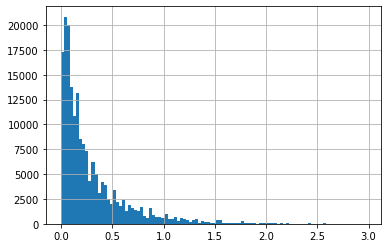

In [32]:
vasopressors_df.mcgkgmin[vasopressors_df.mcgkgmin < 3].hist(bins=100)

In [33]:
# save!
vasopressors_df.to_csv(OUT_DIR + 'vasopressors_mv_cohort.csv', index=False)

---

## Fluids

In [17]:
IV_CATEGORIES = [
    # 25, # Injecties Haematologisch
    55, # Infuus - Crystalloid
    # 27, # Injecties Overig
    # 23, # Injecties CZS/Sedatie/Analgetica
    # 67, # Injecties Hormonen/Vitaminen/Mineralen
    # 65, # 2. Spuitpompen
    # 24, # Injecties Circulatie/Diuretica
    # 15, # Injecties Antimicrobiele middelen
    17, # Infuus - Colloid
    # 61, # Infuus - Bloedproducten
]

# by excluding the following we will (mostly) restrict ourselves to those fluid
# infusions that concern fluid resuscitation, not administration of medication
IV_EXCLUDE = [
    'Vitamine B Complex',
    'Medicijnlijn medicatie',
    'Mannitol 20% Solution',
    'CVVH-Vocht teruggave',
    'Drukzak Heparine',
    'Research PHP/Placebo',
    'Metronidazol-Flagyl',
    'Glucose 40%',
    'Glucose 30%',
    'Glucose 20%',
    'Glucose 10%',
    'Glucose 5 %',
    'Research BHR-100/Placebo',
    'Medicijnlijn spoelen',
    'Drukzak IABP',
    'NaCL 0,9% CO-meting',
]

In [ ]:
fluid_cols = ['admissionid', 'itemid', 'item', 'start', 'stop', 'ordercategory', 'ordercategoryid', 'administered', 'administeredunitid']

iv_fluids_df = []

for i, chunk in pbar(read_csv(r"D:/AmsterdamUMCdb-v1.0.2/drugitems.csv", usecols=fluid_cols)):
    # which treatments were administered starting before 7 days after start admission?
    starttimes = hours_in_admission(chunk.start, chunk.admissionid)
    chunk = chunk[(starttimes > -1) & (starttimes < 168)].copy()
        
    # extract drugitems corresponding to intravenous infusion in ml
    chunk = chunk[chunk.ordercategoryid.isin(IV_CATEGORIES) & ~chunk.item.isin(IV_EXCLUDE) & (chunk.administeredunitid == 6)].copy()
        
    # TODO: tonicity

    # convert to DataFrame
    iv_fluid_df = pd.DataFrame({
        'icustay_id': chunk.admissionid,
        'starttime': to_timestamp(first_admission_start, ms=chunk.start),
        'endtime': to_timestamp(first_admission_start, ms=chunk.stop),
        'itemid': -1, # -1 to prevent conflict with MIMIC itemids
        'ordercategoryname': chunk.ordercategory,
        'amountuom': 'ml',
        'amount': chunk.administered
    })
    iv_fluids_df.append(iv_fluid_df)
    
# merge
iv_fluids_df = pd.concat(iv_fluids_df, axis=0).reset_index(drop=True)
iv_fluids_df.head()

In [15]:
iv_fluids_df.item.value_counts()

NaCl 0,45%/Glucose 2,5%            117779
NaCl 0,9 %                          55547
Drukzak                             46665
Gelofusine                          37100
Ri-Lac (Ringers lactaat)            33057
Glucose 5 %                         14093
Vitamine B Complex                   7993
Medicijnlijn medicatie               5930
Natrium bicarbonaat 8,4 %            2468
Mannitol 20% Solution                2278
Glucose 40%                          2198
Haes 10%                             1791
Albumine 20%                         1697
Natrium bicarbonaat 1.4%              715
NaCL 2,9%                             410
Natriumbicarbonaat  8,4%              409
Voluven                               401
Mannitol 15%                          316
CVVH-Vocht teruggave                  256
X- Crystalloïd nader te bepalen       238
NaCL 0,9% CO-meting                   167
NaCl 0.65 %                           162
Medicijnlijn spoelen                  136
Drukzak IABP                      

In [10]:
# save!
iv_fluids_df.to_csv(OUT_DIR + 'inputevents_mv_cohort.csv', index=False)

--- 
## Statistics

In [41]:
print('Mortality rate: %.3f' % cohort_df.hospital_expire_flag.mean())

Mortality rate: 0.099
